<a href="https://colab.research.google.com/github/jimin-fundamental/ML-2024-fall/blob/main/ML_hw3_finetuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# 1. CIFAR-10 데이터 로드 및 전처리
(X_train_full, y_train_full), (X_test, y_test) = tf.keras.datasets.cifar10.load_data()

# 픽셀 값을 0-1 범위로 정규화
X_train_full, X_test = X_train_full / 255.0, X_test / 255.0
y_train_full, y_test = y_train_full.flatten(), y_test.flatten()

# Validation Set 분리
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.1, random_state=42)

# 2. CNN 모델 정의
def build_cnn_model() -> tf.keras.Model:
    """
    CNN 모델을 구성합니다.
    """
    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(10, activation='softmax')  # 출력 레이어 (10개 클래스)
    ])
    return model

# 3. Fine-tuning 함수 정의
def fine_tune_model(
    optimizer_name: str = 'Adam',
    learning_rate: float = 0.001,
    epochs: int = 10,
    batch_size: int = 32
):
    # 옵티마이저 선택
    if optimizer_name == 'SGD':
        optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)
    elif optimizer_name == 'SGD_with_momentum':
        optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)
    elif optimizer_name == 'RMSprop':
        optimizer = tf.keras.optimizers.RMSprop(learning_rate=learning_rate)
    elif optimizer_name == 'Adam':
        optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    else:
        raise ValueError("Invalid optimizer name")

    # 모델 생성
    model = build_cnn_model()

    # 모델 컴파일
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    # 콜백 설정 (Early Stopping, Learning Rate Scheduler)
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
    lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2)

    # 모델 학습
    history = model.fit(
        X_train, y_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(X_val, y_val),
        callbacks=[early_stopping, lr_scheduler],
        verbose=1
    )

    # 모델 평가
    train_loss, train_acc = model.evaluate(X_train, y_train, verbose=0)
    val_loss, val_acc = model.evaluate(X_val, y_val, verbose=0)
    test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)

    print(f"Training complete with {optimizer_name}, LR={learning_rate}, Epochs={epochs}, Batch size={batch_size}")
    print(f"Train Accuracy: {train_acc:.4f}, Val Accuracy: {val_acc:.4f}, Test Accuracy: {test_acc:.4f}")
    print(f"Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Test Loss: {test_loss:.4f}")

    return model, history, train_acc, val_acc, test_acc



170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 14s 0us/step


In [ ]:
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import precision_score, recall_score, classification_report, confusion_matrix

# Fine-tuning Pipeline
def fine_tuning_pipeline():
    # Hyperparameter candidates
    batch_sizes = [16, 32, 64, 128, 256]
    learning_rates = [0.1, 0.01, 0.001, 0.0001]
    epochs_list = [2, 8, 16, 32]
    optimizers = ['SGD', 'SGD_with_momentum', 'RMSprop', 'Adam']
    nl_act_functions = ['relu', 'sigmoid', 'tanh', 'leaky_relu']

    # Default initial values
    best_params = {
        "batch_size": 32,
        "learning_rate": 0.001,
        "epochs": 10,
        "optimizer": 'Adam',
        "activation_function": 'relu'
    }

    best_accuracy = 0
    best_loss = float('inf')

    # Fine-tuning each hyperparameter sequentially
    for param_name, param_values in [
        ("batch_size", batch_sizes),
        ("learning_rate", learning_rates),
        ("epochs", epochs_list),
        ("optimizer", optimizers),
        ("activation_function", nl_act_functions),
    ]:
        print(f"Fine-tuning {param_name}...")

        val_accuracies = []
        val_losses = []
        best_param_value = None

        for value in param_values:
            # Update current parameter
            current_params = best_params.copy()
            current_params[param_name] = value

            # Train the model with the current parameters
            model, history, train_acc, val_acc, test_acc = fine_tune_model(
                optimizer_name=current_params["optimizer"],
                learning_rate=current_params["learning_rate"],
                epochs=current_params["epochs"],
                batch_size=current_params["batch_size"]
            )

            val_accuracies.append(val_acc)
            val_losses.append(history.history['val_loss'][-1])

            print(f"Testing {param_name}={value}: Validation Accuracy={val_acc:.4f}, Validation Loss={history.history['val_loss'][-1]:.4f}")

            # Update the best parameter if this configuration is better
            if val_acc >= best_accuracy or (val_acc == best_accuracy and history.history['val_loss'][-1] <= best_loss):
                best_accuracy = val_acc
                best_loss = history.history['val_loss'][-1]
                best_param_value = value

        if best_param_value is None:
            best_param_value = best_params[param_name]  #default값
            print(f"No improvement found for {param_name}. Using default value: {best_param_value}")

        # Update the best parameter globally
        best_params[param_name] = best_param_value

        # Plot Validation Accuracy and Loss
        plt.figure(figsize=(10, 4))
        plt.subplot(1, 2, 1)
        plt.plot(param_values, val_accuracies, marker='o', label='Validation Accuracy')
        plt.xlabel(param_name)
        plt.ylabel('Accuracy')
        plt.title(f'Validation Accuracy vs {param_name}')
        plt.grid()
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(param_values, val_losses, marker='o', color='orange', label='Validation Loss')
        plt.xlabel(param_name)
        plt.ylabel('Loss')
        plt.title(f'Validation Loss vs {param_name}')
        plt.grid()
        plt.legend()

        plt.tight_layout()
        plt.show()

    print("Best Parameters:", best_params)

    # ** 최적 하이퍼파라미터로 최종 모델 학습 **
    print("\nTraining and Evaluating the model with Best Parameters...")
    model, history, train_acc, val_acc, test_acc = fine_tune_model(
        optimizer_name=best_params["optimizer"],
        learning_rate=best_params["learning_rate"],
        epochs=best_params["epochs"],
        batch_size=best_params["batch_size"]
    )

    # ** 테스트 셋 평가 **
    test_loss, test_acc = model.evaluate(X_test, y_test)
    print(f"Test accuracy: {test_acc:.4f}")

    # ** 추가 메트릭 계산 및 시각화 **
    y_pred = model.predict(X_test).argmax(axis=1)

    precision = precision_score(y_test, y_pred, average='macro')
    recall = recall_score(y_test, y_pred, average='macro')
    print(f"Test Precision: {precision:.4f}")
    print(f"Test Recall: {recall:.4f}")

    # Confusion Matrix
    conf_mat = confusion_matrix(y_test, y_pred)
    print("Confusion Matrix:")
    print(conf_mat)

    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

    # Classification Report
    print("Classification Report:")
    print(classification_report(y_test, y_pred, target_names=class_names))

Fine-tuning batch_size...


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
2813/2813 ━━━━━━━━━━━━━━━━━━━━ 16s 4ms/step - accuracy: 0.3719 - loss: 1.7004 - val_accuracy: 0.5644 - val_loss: 1.2122 - learning_rate: 0.0010
Epoch 2/10
2813/2813 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.5976 - loss: 1.1391 - val_accuracy: 0.6310 - val_loss: 1.0356 - learning_rate: 0.0010
Epoch 3/10
2813/2813 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.6726 - loss: 0.9352 - val_accuracy: 0.6666 - val_loss: 0.9558 - learning_rate: 0.0010
Epoch 4/10
2813/2813 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.7142 - loss: 0.8138 - val_accuracy: 0.6738 - val_loss: 0.9336 - learning_rate: 0.0010
Epoch 5/10
2813/2813 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.7484 - loss: 0.7077 - val_accuracy: 0.7050 - val_loss: 0.8561 - learning_rate: 0.0010
Epoch 6/10
2813/2813 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.7799 - loss: 0.6201 - val_accuracy: 0.6866 - val_loss: 0.9519 - learning_rate: 0.0010
Epoch 7/10
2813/2813 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.8073

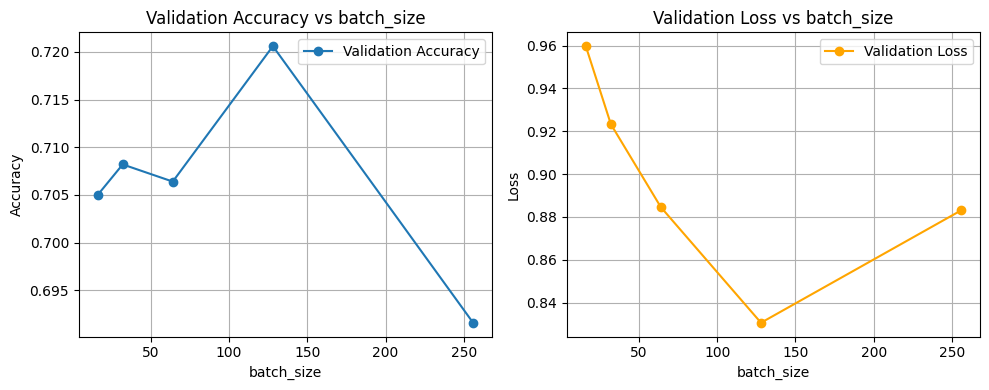

Fine-tuning learning_rate...
Epoch 1/10
352/352 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - accuracy: 0.0997 - loss: 989.2269 - val_accuracy: 0.1018 - val_loss: 2.3051 - learning_rate: 0.1000
Epoch 2/10
352/352 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.0992 - loss: 2.3082 - val_accuracy: 0.1018 - val_loss: 2.3038 - learning_rate: 0.1000
Epoch 3/10
352/352 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.0949 - loss: 2.3082 - val_accuracy: 0.1018 - val_loss: 2.3100 - learning_rate: 0.1000
Epoch 4/10
352/352 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.1024 - loss: 2.3089 - val_accuracy: 0.1006 - val_loss: 2.3035 - learning_rate: 0.1000
Epoch 5/10
352/352 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.0997 - loss: 2.3079 - val_accuracy: 0.1054 - val_loss: 2.3056 - learning_rate: 0.1000
Epoch 6/10
352/352 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.1020 - loss: 2.3076 - val_accuracy: 0.0972 - val_loss: 2.3082 - learning_rate: 0.1000
Epoch 7/10
352/352 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - ac

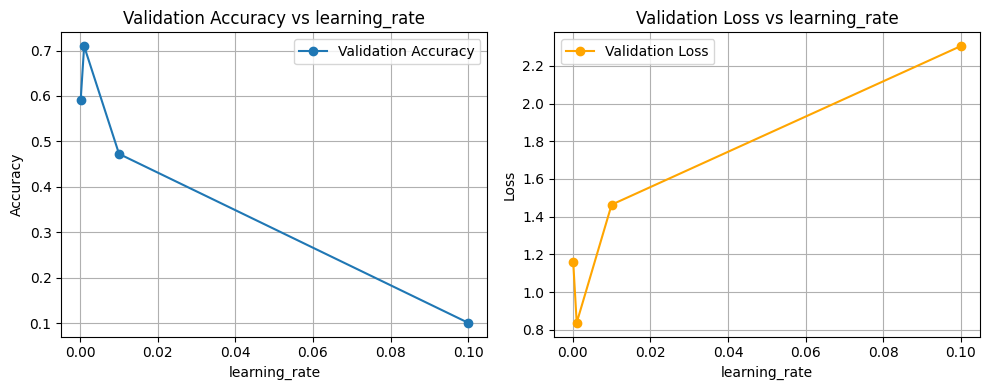

Fine-tuning epochs...
Epoch 1/2
352/352 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.3138 - loss: 1.8534 - val_accuracy: 0.5032 - val_loss: 1.3861 - learning_rate: 0.0010
Epoch 2/2
352/352 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.5410 - loss: 1.2947 - val_accuracy: 0.5980 - val_loss: 1.1367 - learning_rate: 0.0010
Training complete with Adam, LR=0.001, Epochs=2, Batch size=128
Train Accuracy: 0.6116, Val Accuracy: 0.5980, Test Accuracy: 0.5911
Train Loss: 1.1150, Val Loss: 1.1367, Test Loss: 1.1462
Testing epochs=2: Validation Accuracy=0.5980, Validation Loss=1.1367
Epoch 1/8
352/352 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.3292 - loss: 1.8199 - val_accuracy: 0.4912 - val_loss: 1.3884 - learning_rate: 0.0010
Epoch 2/8
352/352 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.5290 - loss: 1.3116 - val_accuracy: 0.5816 - val_loss: 1.1608 - learning_rate: 0.0010
Epoch 3/8
352/352 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.6040 - loss: 1.1287 - val_accuracy: 0.6180 - val_l

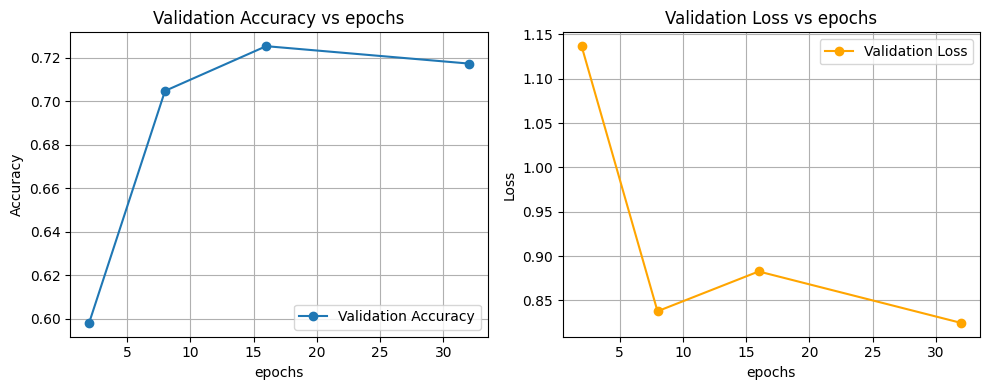

Fine-tuning optimizer...
Epoch 1/16
352/352 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.1013 - loss: 2.3007 - val_accuracy: 0.1266 - val_loss: 2.2972 - learning_rate: 0.0010
Epoch 2/16
352/352 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.1362 - loss: 2.2950 - val_accuracy: 0.1336 - val_loss: 2.2927 - learning_rate: 0.0010
Epoch 3/16
352/352 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.1380 - loss: 2.2901 - val_accuracy: 0.1282 - val_loss: 2.2880 - learning_rate: 0.0010
Epoch 4/16
352/352 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.1389 - loss: 2.2861 - val_accuracy: 0.1272 - val_loss: 2.2823 - learning_rate: 0.0010
Epoch 5/16
352/352 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.1409 - loss: 2.2786 - val_accuracy: 0.1396 - val_loss: 2.2750 - learning_rate: 0.0010
Epoch 6/16
352/352 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.1502 - loss: 2.2706 - val_accuracy: 0.1554 - val_loss: 2.2653 - learning_rate: 0.0010
Epoch 7/16
352/352 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy

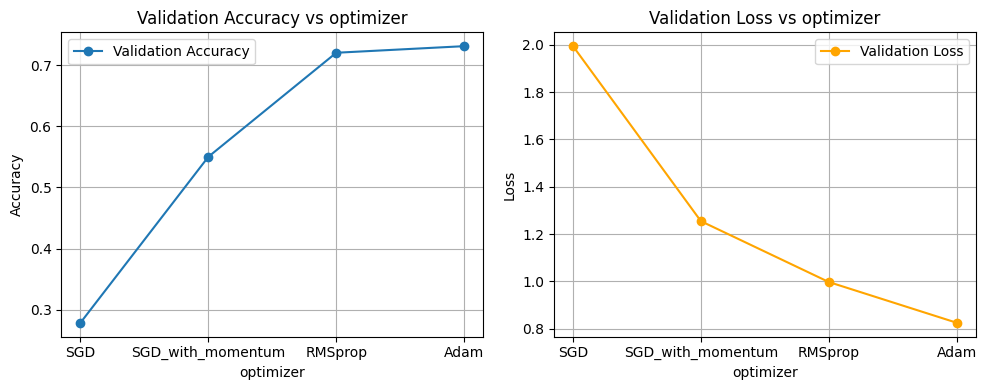

Fine-tuning activation_function...
Epoch 1/16
352/352 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.3151 - loss: 1.8540 - val_accuracy: 0.4938 - val_loss: 1.3855 - learning_rate: 0.0010
Epoch 2/16
352/352 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.5272 - loss: 1.3195 - val_accuracy: 0.5650 - val_loss: 1.2052 - learning_rate: 0.0010
Epoch 3/16
352/352 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.5944 - loss: 1.1526 - val_accuracy: 0.6194 - val_loss: 1.0869 - learning_rate: 0.0010
Epoch 4/16
352/352 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.6420 - loss: 1.0217 - val_accuracy: 0.6326 - val_loss: 1.0279 - learning_rate: 0.0010
Epoch 5/16
352/352 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.6754 - loss: 0.9300 - val_accuracy: 0.6624 - val_loss: 0.9420 - learning_rate: 0.0010
Epoch 6/16
352/352 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7037 - loss: 0.8461 - val_accuracy: 0.6856 - val_loss: 0.9050 - learning_rate: 0.0010
Epoch 7/16
352/352 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step 

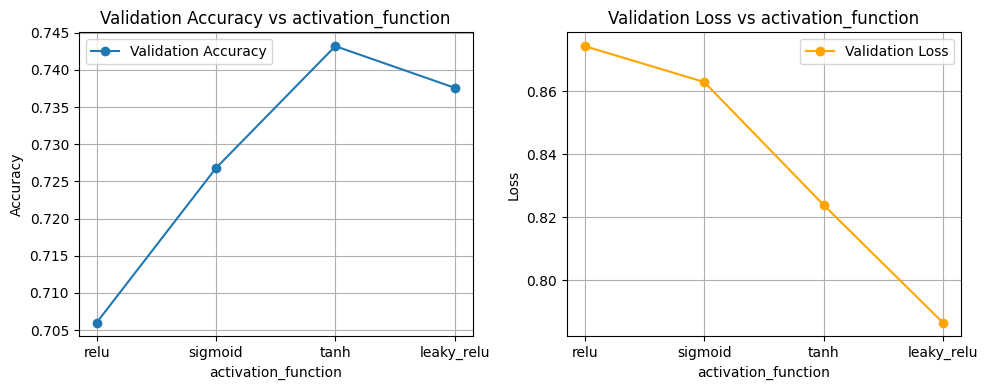

Best Parameters: {'batch_size': 128, 'learning_rate': 0.001, 'epochs': 16, 'optimizer': 'Adam', 'activation_function': 'tanh'}

Training and Evaluating the model with Best Parameters...
Epoch 1/16
352/352 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.3175 - loss: 1.8671 - val_accuracy: 0.5144 - val_loss: 1.3492 - learning_rate: 0.0010
Epoch 2/16
352/352 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.5484 - loss: 1.2826 - val_accuracy: 0.5956 - val_loss: 1.1440 - learning_rate: 0.0010
Epoch 3/16
352/352 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.6093 - loss: 1.1169 - val_accuracy: 0.6302 - val_loss: 1.0396 - learning_rate: 0.0010
Epoch 4/16
352/352 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.6550 - loss: 0.9943 - val_accuracy: 0.6640 - val_loss: 0.9686 - learning_rate: 0.0010
Epoch 5/16
352/352 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.6882 - loss: 0.8925 - val_accuracy: 0.6836 - val_loss: 0.9099 - learning_rate: 0.0010
Epoch 6/16
352/352 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step -

NameError: name 'class_names' is not defined

<Figure size 1000x800 with 0 Axes>

In [ ]:
# Fine-tuning Pipeline 실행
if __name__ == "__main__":
    fine_tuning_pipeline()

activation function 추가

In [5]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# 1. CIFAR-10 데이터 로드 및 전처리
(X_train_full, y_train_full), (X_test, y_test) = tf.keras.datasets.cifar10.load_data()

# 픽셀 값을 0-1 범위로 정규화
X_train_full, X_test = X_train_full / 255.0, X_test / 255.0
y_train_full, y_test = y_train_full.flatten(), y_test.flatten()

# Validation Set 분리
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.1, random_state=42)

# 2. CNN 모델 정의
def build_cnn_model(activation_function: str = 'relu') -> tf.keras.Model:
    """
    CNN 모델을 구성하며, 활성화 함수를 매개변수로 받습니다.
    """
    # Leaky ReLU 사용 처리
    activation_layer = None
    if activation_function == 'leaky_relu':
        activation_layer = tf.keras.layers.LeakyReLU()  # 객체로 전달
    else:
        activation_layer = activation_function  # 문자열로 전달

    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(32, (3, 3), activation=activation_layer, input_shape=(32, 32, 3)),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(64, (3, 3), activation=activation_layer),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(128, (3, 3), activation=activation_layer),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation=activation_layer),
        tf.keras.layers.Dense(10, activation='softmax')  # 출력 레이어
    ])
    return model


# 3. Fine-tuning 함수 정의
def fine_tune_model(
    optimizer_name: str = 'Adam',
    learning_rate: float = 0.001,
    epochs: int = 10,
    batch_size: int = 32,
    activation_function: str = 'relu'  # 활성화 함수 추가
):
    # 옵티마이저 선택
    if optimizer_name == 'SGD':
        optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)
    elif optimizer_name == 'SGD_with_momentum':
        optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)
    elif optimizer_name == 'RMSprop':
        optimizer = tf.keras.optimizers.RMSprop(learning_rate=learning_rate)
    elif optimizer_name == 'Adam':
        optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    else:
        raise ValueError("Invalid optimizer name")

    # 모델 생성
    model = build_cnn_model(activation_function=activation_function)

    # 모델 컴파일
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    # 콜백 설정 (Early Stopping, Learning Rate Scheduler)
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
    lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2)

    # 모델 학습
    history = model.fit(
        X_train, y_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(X_val, y_val),
        callbacks=[early_stopping, lr_scheduler],
        verbose=1
    )

    # 모델 평가
    train_loss, train_acc = model.evaluate(X_train, y_train, verbose=0)
    val_loss, val_acc = model.evaluate(X_val, y_val, verbose=0)
    test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)

    print(f"Training complete with {optimizer_name}, LR={learning_rate}, Epochs={epochs}, Batch size={batch_size}")
    print(f"Train Accuracy: {train_acc:.4f}, Val Accuracy: {val_acc:.4f}, Test Accuracy: {test_acc:.4f}")
    print(f"Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Test Loss: {test_loss:.4f}")

    return model, history, train_acc, val_acc, test_acc



In [6]:
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import precision_score, recall_score, classification_report, confusion_matrix

# Fine-tuning Pipeline
def fine_tuning_pipeline():
    # Hyperparameter candidates
    batch_sizes = [16, 32, 64, 128, 256]
    learning_rates = [0.1, 0.01, 0.001, 0.0001]
    epochs_list = [2, 8, 16, 32]
    optimizers = ['SGD', 'SGD_with_momentum', 'RMSprop', 'Adam']
    nl_act_functions = ['relu', 'sigmoid', 'tanh', 'leaky_relu']

    # Default initial values
    best_params = {
        "batch_size": 128,
        "learning_rate": 0.001,
        "epochs": 16,
        "optimizer": 'Adam',
        "activation_function": 'relu'
    }

    best_accuracy = 0
    best_loss = float('inf')

    # Fine-tuning each hyperparameter sequentially
    for param_name, param_values in [
        # ("batch_size", batch_sizes),
        # ("learning_rate", learning_rates),
        # ("epochs", epochs_list),
        # ("optimizer", optimizers),
        ("activation_function", nl_act_functions)
    ]:
        print(f"Fine-tuning {param_name}...")

        val_accuracies = []
        val_losses = []
        best_param_value = None

        for value in param_values:
            # Update current parameter
            current_params = best_params.copy()
            current_params[param_name] = value

            # Train the model with the current parameters
            model, history, train_acc, val_acc, test_acc = fine_tune_model(
                # optimizer_name=current_params["optimizer"],
                # learning_rate=current_params["learning_rate"],
                # epochs=current_params["epochs"],
                # batch_size=current_params["batch_size"],
                activation_function=current_params["activation_function"]  # 활성화 함수 전달
            )

            val_accuracies.append(val_acc)
            val_losses.append(history.history['val_loss'][-1])

            print(f"Testing {param_name}={value}: Validation Accuracy={val_acc:.4f}, Validation Loss={history.history['val_loss'][-1]:.4f}")

            # Update the best parameter if this configuration is better
            if val_acc >= best_accuracy or (val_acc == best_accuracy and history.history['val_loss'][-1] <= best_loss):
                best_accuracy = val_acc
                best_loss = history.history['val_loss'][-1]
                best_param_value = value

        if best_param_value is None:
            best_param_value = best_params[param_name]  #default값
            print(f"No improvement found for {param_name}. Using default value: {best_param_value}")

        # Update the best parameter globally
        best_params[param_name] = best_param_value

        # Plot Validation Accuracy and Loss
        plt.figure(figsize=(10, 4))
        plt.subplot(1, 2, 1)
        plt.plot(param_values, val_accuracies, marker='o', label='Validation Accuracy')
        plt.xlabel(param_name)
        plt.ylabel('Accuracy')
        plt.title(f'Validation Accuracy vs {param_name}')
        plt.grid()
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(param_values, val_losses, marker='o', color='orange', label='Validation Loss')
        plt.xlabel(param_name)
        plt.ylabel('Loss')
        plt.title(f'Validation Loss vs {param_name}')
        plt.grid()
        plt.legend()

        plt.tight_layout()
        plt.show()

    print("Best Parameters:", best_params)

    # ** 최적 하이퍼파라미터로 최종 모델 학습 **
    print("\nTraining and Evaluating the model with Best Parameters...")
    model, history, train_acc, val_acc, test_acc = fine_tune_model(
        optimizer_name=best_params["optimizer"],
        learning_rate=best_params["learning_rate"],
        epochs=best_params["epochs"],
        batch_size=best_params["batch_size"]
    )

    # ** 테스트 셋 평가 **
    test_loss, test_acc = model.evaluate(X_test, y_test)
    print(f"Test accuracy: {test_acc:.4f}")

    # ** 추가 메트릭 계산 및 시각화 **
    y_pred = model.predict(X_test).argmax(axis=1)

    precision = precision_score(y_test, y_pred, average='macro')
    recall = recall_score(y_test, y_pred, average='macro')
    print(f"Test Precision: {precision:.4f}")
    print(f"Test Recall: {recall:.4f}")

    class_names = [
    "airplane", "automobile", "bird", "cat", "deer",
    "dog", "frog", "horse", "ship", "truck"
]

    # Confusion Matrix
    conf_mat = confusion_matrix(y_test, y_pred)
    print("Confusion Matrix:")
    print(conf_mat)

    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

    # Classification Report
    print("Classification Report:")
    print(classification_report(y_test, y_pred, target_names=class_names))

Fine-tuning activation_function...
Epoch 1/10
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.3690 - loss: 1.7158 - val_accuracy: 0.5678 - val_loss: 1.2037 - learning_rate: 0.0010
Epoch 2/10
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.5864 - loss: 1.1611 - val_accuracy: 0.6150 - val_loss: 1.1008 - learning_rate: 0.0010
Epoch 3/10
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.6510 - loss: 0.9937 - val_accuracy: 0.6714 - val_loss: 0.9317 - learning_rate: 0.0010
Epoch 4/10
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.7034 - loss: 0.8450 - val_accuracy: 0.6862 - val_loss: 0.9049 - learning_rate: 0.0010
Epoch 5/10
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.7391 - loss: 0.7418 - val_accuracy: 0.7044 - val_loss: 0.8509 - learning_rate: 0.0010
Epoch 6/10
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.7710 - loss: 0.6598 - val_accuracy: 0.7106 - val_loss: 0.8247 - learning_rate: 0.0010
Epoch 7/10
1407/1407 ━━━━━━━━━━━━━━━━━━━

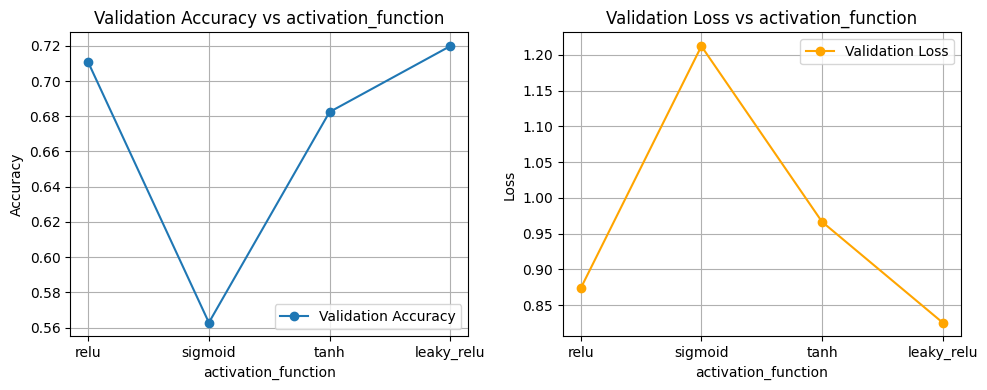

Best Parameters: {'batch_size': 128, 'learning_rate': 0.001, 'epochs': 16, 'optimizer': 'Adam', 'activation_function': 'leaky_relu'}

Training and Evaluating the model with Best Parameters...
Epoch 1/16
352/352 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - accuracy: 0.3177 - loss: 1.8571 - val_accuracy: 0.4940 - val_loss: 1.4164 - learning_rate: 0.0010
Epoch 2/16
352/352 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.5357 - loss: 1.3098 - val_accuracy: 0.5900 - val_loss: 1.1502 - learning_rate: 0.0010
Epoch 3/16
352/352 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.6159 - loss: 1.0898 - val_accuracy: 0.6270 - val_loss: 1.0556 - learning_rate: 0.0010
Epoch 4/16
352/352 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.6534 - loss: 0.9955 - val_accuracy: 0.6506 - val_loss: 1.0058 - learning_rate: 0.0010
Epoch 5/16
352/352 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.6907 - loss: 0.8869 - val_accuracy: 0.6914 - val_loss: 0.8793 - learning_rate: 0.0010
Epoch 6/16
352/352 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/

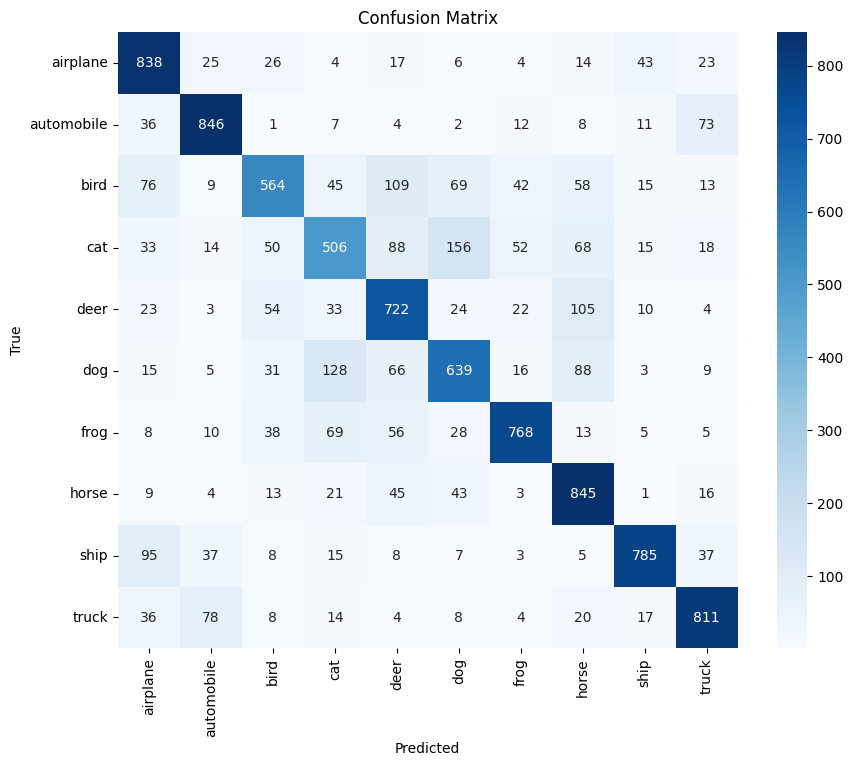

Classification Report:
              precision    recall  f1-score   support

    airplane       0.72      0.84      0.77      1000
  automobile       0.82      0.85      0.83      1000
        bird       0.71      0.56      0.63      1000
         cat       0.60      0.51      0.55      1000
        deer       0.65      0.72      0.68      1000
         dog       0.65      0.64      0.64      1000
        frog       0.83      0.77      0.80      1000
       horse       0.69      0.84      0.76      1000
        ship       0.87      0.79      0.82      1000
       truck       0.80      0.81      0.81      1000

    accuracy                           0.73     10000
   macro avg       0.73      0.73      0.73     10000
weighted avg       0.73      0.73      0.73     10000



In [7]:
# Fine-tuning Pipeline 실행
if __name__ == "__main__":
    fine_tuning_pipeline()